# Explaining the GNN

The pretrained Edge-Conditioned Graph Neural Network (EC-GNN) is loaded and analyzed using an extended GNNExplainer. The node and edge features are first extracted from CSV files and reshaped to represent the 6-node and 11-edge topology of each test graph, defined by a fixed edge_index.

After loading the trained model `Case6_Full.pth`, the explainer is configured to compute feature-level attributions across nodes and edges. Although the original GNNExplainer focuses on identifying important nodes and edges within the graph structure, this work extends its functionality to quantify the contribution of individual edge features.

The process iterates over 20,000 graph instances, aggregates normalized importance scores, and exports them to CSV files for visualization.

Let's start with importing the necessary libraries

In [ ]:
import torch
import pandas as pd
import numpy as np
from tqdm import tqdm
import torch.nn.functional as F

from torch_geometric.data import Data
from torch_geometric.nn import global_mean_pool, MessagePassing
from torch_geometric.explain import Explainer, GNNExplainer
from torch_geometric.explain.config import ModelConfig, ModelMode, ExplanationType, MaskType

In this step, the node and edge feature names are extracted from the dataset headers. The corresponding numerical data are then reshaped to represent the 6 nodes and 11 edges that define each graph instance in the 6-bus test system.

In [ ]:
# Load node and edge feature names from CSV headers
node_feature_names = pd.read_csv('Node_Features.csv', nrows=0).columns.tolist()
edge_feature_names = pd.read_csv('Edge_Features.csv', nrows=0).columns.tolist()

# Load full test data
X_test_np = pd.read_csv('Node_Features.csv').to_numpy().reshape(-1, 6, 2)
E_test_np = pd.read_csv('Edge_Features.csv').to_numpy().reshape(-1, 11, 2)

edge_index = torch.tensor([
    [0, 0, 0, 1, 1, 1, 1, 2, 2, 3, 4],
    [1, 3, 4, 2, 3, 4, 5, 4, 5, 4, 5]
], dtype=torch.long)

The core architecture of the EC-GNN is defined. The model builds upon the ECC layer. The network consists of two ECC layers followed by fully connected layers for classification. After defining the model structure, the pretrained weights `Case6_Full.pth` are loaded onto the available device (CPU or GPU) for evaluation.

In [ ]:
# Define ECC layer and EC-GNN
class EdgeConditionedConv(MessagePassing):
    def __init__(self, in_channels_node, in_channels_edge, out_channels):
        super().__init__(aggr='mean')
        self.mlp = torch.nn.Sequential(
            torch.nn.Linear(2 * in_channels_node + in_channels_edge, out_channels),
            torch.nn.ReLU(),
            torch.nn.Linear(out_channels, out_channels)
        )

    def forward(self, x, edge_index, edge_attr):
        from torch_geometric.utils import add_self_loops
        edge_index, _ = add_self_loops(edge_index, num_nodes=x.size(0))
        loop_attr = torch.zeros(x.size(0), edge_attr.size(1), device=edge_attr.device)
        edge_attr = torch.cat([edge_attr, loop_attr], dim=0)
        return self.propagate(edge_index, x=x, edge_attr=edge_attr)

    def message(self, x_i, x_j, edge_attr):
        return self.mlp(torch.cat([x_i, x_j, edge_attr], dim=-1))

class ECGNN(torch.nn.Module):
    def __init__(self, in_channels_node, in_channels_edge, hidden_channels, out_channels):
        super().__init__()
        self.conv1 = EdgeConditionedConv(in_channels_node, in_channels_edge, hidden_channels)
        self.conv2 = EdgeConditionedConv(hidden_channels, in_channels_edge, hidden_channels)
        self.fc1 = torch.nn.Linear(hidden_channels, hidden_channels // 2)
        self.fc2 = torch.nn.Linear(hidden_channels // 2, out_channels)

    def forward(self, x, edge_index, edge_attr, batch):
        x = self.conv1(x, edge_index, edge_attr)
        x = F.leaky_relu(x)
        x = self.conv2(x, edge_index, edge_attr)
        x = F.leaky_relu(x)
        x = global_mean_pool(x, batch)
        x = F.leaky_relu(self.fc1(x))
        return self.fc2(x)

# Load the model
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = torch.load('Case6_Full.pth', map_location=device)
model.to(device)
model.eval()

This is the "core" cell. The approach is based on the GNNExplainer algorithm but extends its standard formulation to operate at the feature level for both nodes and edges.

The ModelConfig is first defined for a graph-level multiclass classification task, where each graph corresponds to a power system snapshot, and the model output represents one of 17 possible classes. The extended explainer is then wrapped around the trained EC-GNN to analyze its learned internal representations. While the traditional GNNExplainer focuses on identifying subgraphs or critical nodes, the version implemented here introduces the following enhancements:

* Node Feature Attribution – Instead of highlighting only influential nodes, the explainer extracts feature-level importance scores across all 6 nodes and their 2 features.

* Edge Feature Attribution – The framework couples the edge masks generated by the explainer with their corresponding edge attributes. This step generalizes the explainer’s functionality, making it suitable for power system graphs where edges carry physically meaningful quantities.

* The process is iterated over 20,000 test graphs, ensuring statistical robustness in the resulting importance values. For each graph, node and edge feature masks are accumulated, averaged, and normalized to produce interpretable global importance measures.

The normalized scores are then exported as 2 separate CSV files, providing a ranked view of the most influential features from both network layers.

In [ ]:
# Model config
model_config = ModelConfig(
    mode=ModelMode.multiclass_classification,
    task_level='graph',
    return_type='log_probs'
)

# GNNExplainer wrapper
explainer = Explainer(
    model=model,
    algorithm=GNNExplainer(epochs=200),
    explanation_type=ExplanationType.model,
    node_mask_type=MaskType.attributes,
    edge_mask_type=MaskType.object,
    model_config=model_config,
)

# Accumulate importance scores
node_feature_scores = np.zeros(len(node_feature_names))
edge_feature_scores = np.zeros(len(edge_feature_names))

# Process 2,000 graphs
num_graphs = 20000
for i in tqdm(range(num_graphs)):
    x = torch.tensor(X_test_np[i], dtype=torch.float32).to(device)
    edge_attr = torch.tensor(E_test_np[i], dtype=torch.float32).to(device)
    batch = torch.zeros(x.size(0), dtype=torch.long).to(device)

    data = Data(x=x, edge_index=edge_index.to(device), edge_attr=edge_attr, batch=batch)

    explanation = explainer(
        x=data.x,
        edge_index=data.edge_index,
        edge_attr=data.edge_attr,
        batch=data.batch,
        index=0
    )

    # Add node feature mask
    #node_mask = explanation.node_mask.mean(dim=0).detach().cpu().numpy()
    #node_feature_scores += node_mask
    node_mask = explanation.node_mask.detach().cpu().numpy().flatten()  # shape: (6 * 2 = 12,)
    node_feature_scores += node_mask

    # Add edge feature mask
    edge_attr_np = edge_attr.detach().cpu().numpy().flatten()  # shape (11 * 2 = 22,)
    edge_mask_np = explanation.edge_mask.detach().cpu().numpy()  # shape (11,)

    edge_importances = edge_mask_np.repeat(edge_attr_np.shape[0] // edge_mask_np.shape[0]) * edge_attr_np
    edge_feature_scores += edge_importances

# Normalize scores
node_feature_scores /= num_graphs
edge_feature_scores /= num_graphs

# Save to CSV
df_node = pd.DataFrame({'Feature': node_feature_names, 'AttentionScore': node_feature_scores})
df_edge = pd.DataFrame({'Feature': edge_feature_names, 'AttentionScore': edge_feature_scores})

df_node.to_csv('Node_Feature_Importance.csv', index=False)
df_edge.to_csv('Edge_Feature_Importance.csv', index=False)

print(df_node)
print(df_edge)

# Visualizations

THis was can be done separately, provided the feature importance scores are extract from the above code.

Import the necessary library.

In [ ]:
import matplotlib.pyplot as plt

Read the CSV files.

In [ ]:
edge_df = pd.read_csv("Edge_Feature_Importance.csv")
node_df = pd.read_csv("Node_Feature_Importance.csv")

This section visualizes the average importance scores obtained from the explainability framework for all node features in the 6-bus system.

The figure presents a bar chart of the normalized importance scores, highlighting which node-level electrical quantities most strongly influence the EC-GNN’s classification decisions.

The below figure is found under the Supplementary Material in the IEEE database.

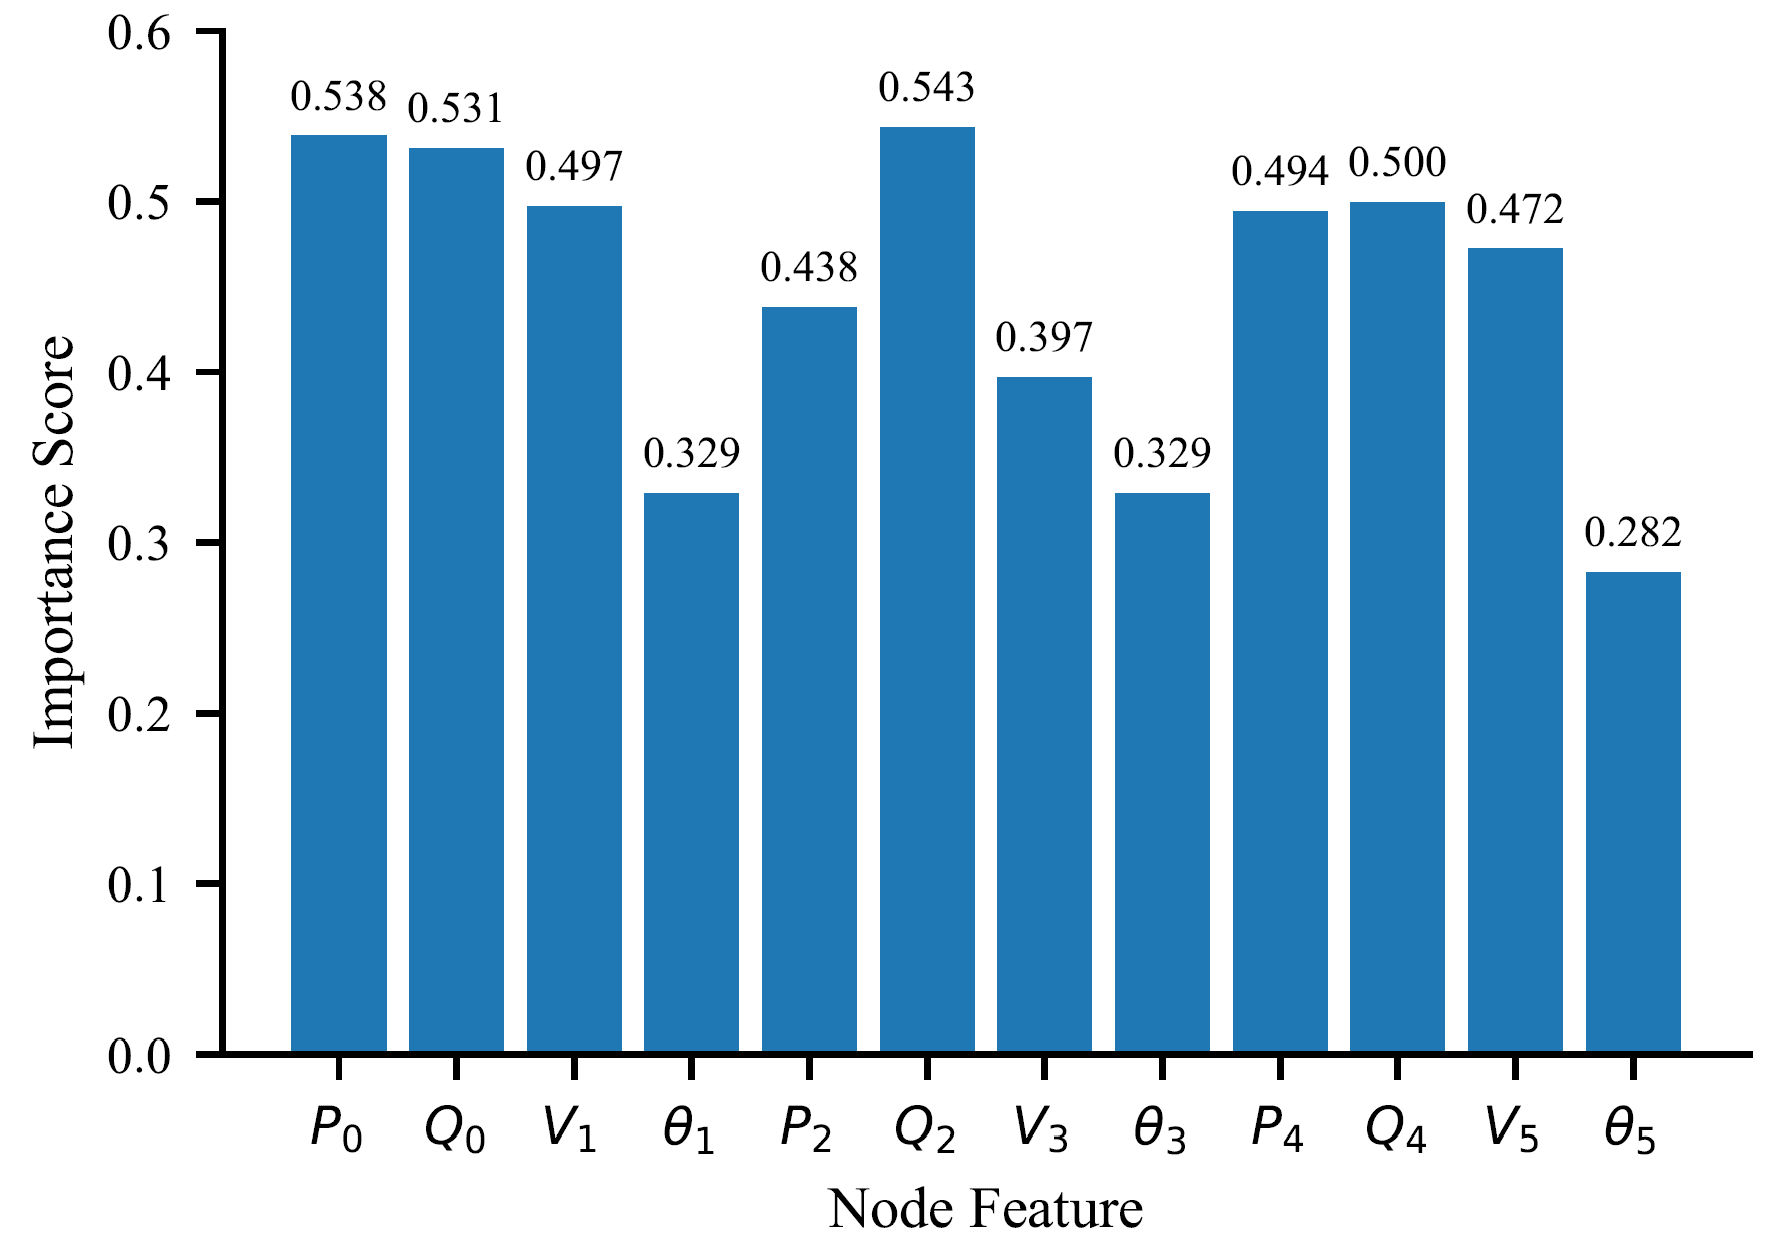

In [ ]:
# Define node feature labels in LaTeX
node_df['Feature'] = [
    r"$P_0$", r"$Q_0$", r"$V_1$", r"$\theta_1$",
    r"$P_2$", r"$Q_2$", r"$V_3$", r"$\theta_3$",
    r"$P_4$", r"$Q_4$", r"$V_5$", r"$\theta_5$"
]

plt.rcParams.update({
    'font.family': 'Times New Roman',
    'font.size': 8,
    'axes.titlesize': 8,
    'axes.labelsize': 8,
    'xtick.labelsize': 7,
    'ytick.labelsize': 7,
    'legend.fontsize': 7
})

fig, ax = plt.subplots(figsize=(3.5, 2.6))

bars = ax.bar(node_df['Feature'], node_df['AttentionScore'])

ax.set_xlabel("Node Feature", labelpad=3)
ax.set_ylabel("Importance Score", labelpad=3)

ax.set_ylim(0, 0.6)
ax.set_yticks(np.arange(0.0, 0.7, 0.1))

ax.tick_params(axis='x', rotation=0)

ax.grid(False)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

for bar in bars:
    height = bar.get_height()
    ax.text(bar.get_x() + bar.get_width() / 2, height + 0.01, f"{height:.3f}",
            ha='center', va='bottom', fontsize=6)

plt.tight_layout()
plt.savefig("Node_Importance.pdf", format='pdf', bbox_inches='tight')
plt.savefig("Node_Importance.eps", format='eps', bbox_inches='tight')
plt.show()

Similarly, this section visualizes the average importance scores obtained from the explainability framework for all edge features in the 6-bus system.

The figure presents a bar chart of the normalized importance scores, highlighting which edge-level electrical quantities most strongly influence the EC-GNN’s classification decisions.

The below figure is found under the Supplementary Material in the IEEE database.

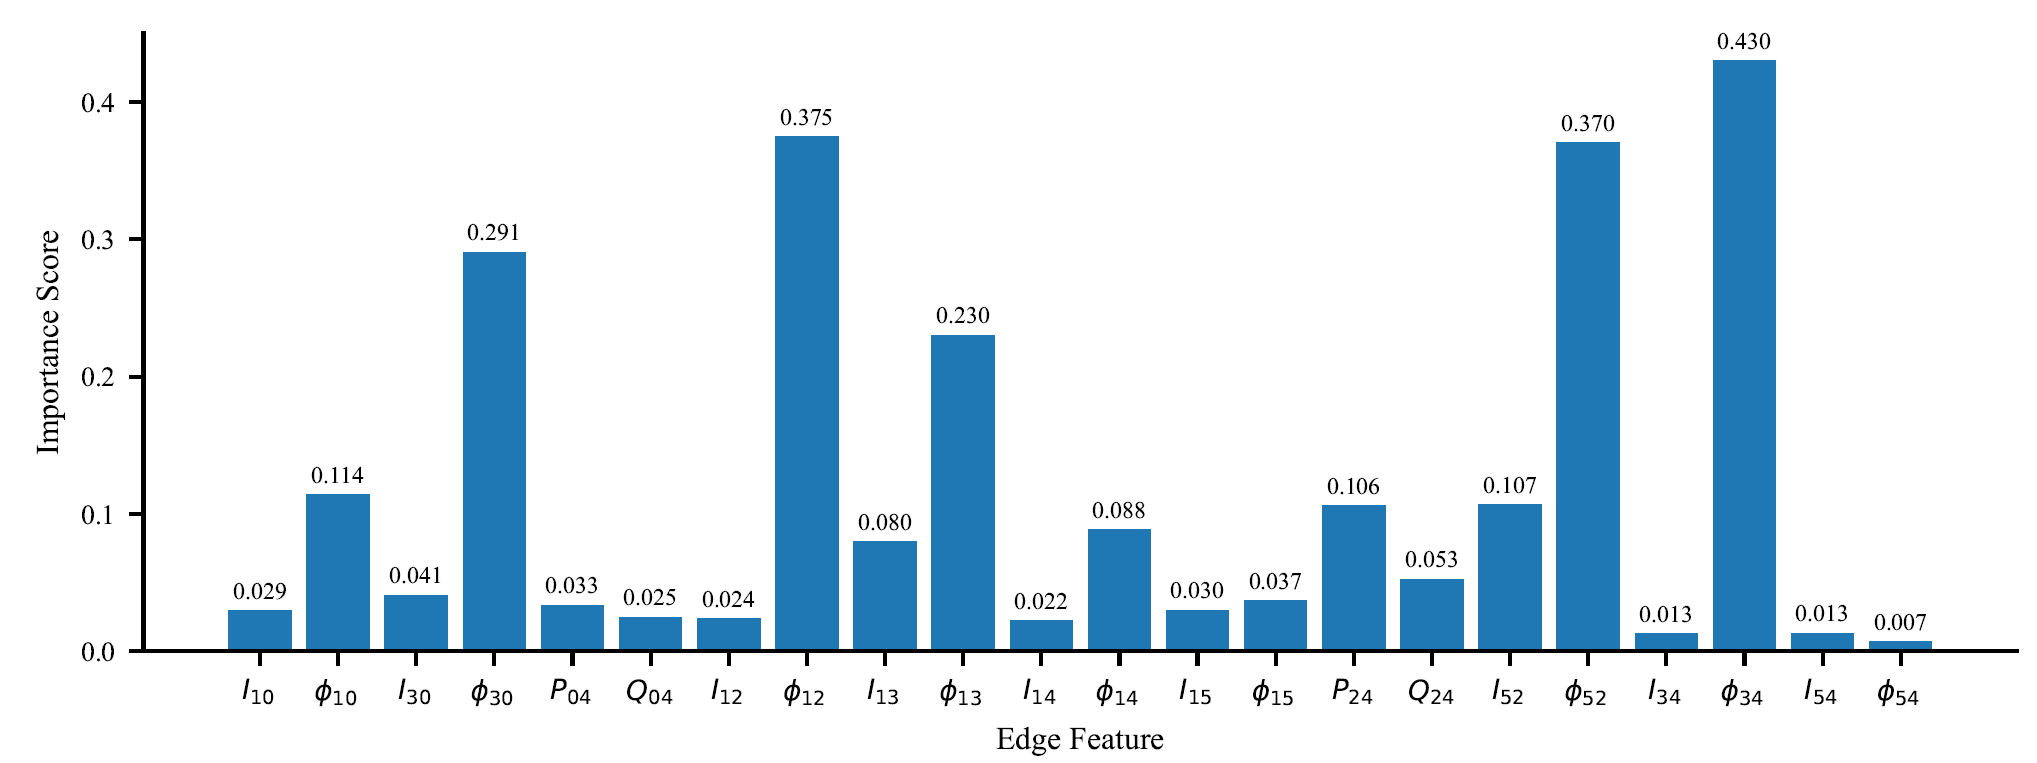

In [ ]:
edge_df['Feature'] = [
    r"$I_{10}$", r"$\phi_{10}$", r"$I_{30}$", r"$\phi_{30}$", r"$P_{04}$", r"$Q_{04}$",
    r"$I_{12}$", r"$\phi_{12}$", r"$I_{13}$", r"$\phi_{13}$", r"$I_{14}$", r"$\phi_{14}$",
    r"$I_{15}$", r"$\phi_{15}$", r"$P_{24}$", r"$Q_{24}$", r"$I_{52}$", r"$\phi_{52}$",
    r"$I_{34}$", r"$\phi_{34}$", r"$I_{54}$", r"$\phi_{54}$"
]

plt.rcParams.update({
    'font.family': 'Times New Roman',
    'font.size': 8,
    'axes.titlesize': 8,
    'axes.labelsize': 8,
    'xtick.labelsize': 7,
    'ytick.labelsize': 7,
    'legend.fontsize': 7
})

fig, ax = plt.subplots(figsize=(7.16, 2.8))

bars = ax.bar(edge_df['Feature'], edge_df['AttentionScore'])

ax.set_xlabel("Edge Feature", labelpad=4)
ax.set_ylabel("Importance Score", labelpad=4)

ax.set_ylim(0, 0.45)
ax.set_yticks(np.arange(0.0, 0.5, 0.1))

ax.tick_params(axis='x', rotation=00)

ax.grid(False)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

for bar in bars:
    height = bar.get_height()
    ax.text(bar.get_x() + bar.get_width() / 2, height + 0.005, f"{height:.3f}",
            ha='center', va='bottom', fontsize=6)

plt.tight_layout()

plt.savefig("Edge_Importance.pdf", format='pdf', bbox_inches='tight')
plt.savefig("Edge_Importance.eps", format='eps', bbox_inches='tight')
plt.show()